In [1]:
#import geopy
#from geopy.distance import distance
import numpy as np
#import seawater as sw
#from shapely.geometry import Point
#from shapely.geometry.polygon import Polygon
import xarray as xr
from matplotlib.path import Path
import os
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import glob

In [8]:
def unpickle_var(fname):
    with open(fname, 'rb') as pfile:
        return pickle.load(pfile)


def setup_plot():
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'rotation': 45}
    return ax


def find_unique_colors(colormap='gist_rainbow', num_colors=20):
    cm = plt.get_cmap(colormap)
    my_colors=[cm(1.*i/num_colors) for i in range(num_colors)]
    return my_colors


def create_plot(cfile, savedir, set_extent=True):
    bname = os.path.basename(cfile).split('.')[0]
    ax = setup_plot()
    
    with xr.open_dataset(cfile) as ds:
        
        # plot each model track
        for md in range(0, len(ds.model_run.values)):
            plt.plot(ds.mod_lon.values[md], ds.mod_lat.values[md], color='red', linestyle='-', linewidth=0.5)
            
        # add the observed track
        for ot in range(0, len(ds.obs_lon)):
            plt.plot(ds.obs_lon.values[ot], ds.obs_lat.values[ot], color='black', linestyle='-', linewidth=1)
            if ot == 0:
                plt.plot(ds.obs_lon.values[ot][0], ds.obs_lat.values[ot][0], 'o', color='green', markersize=6)

    if set_extent:    
        # set the limits now so that the mesh isn't used to decide the plot extent
        data_xlims = list(ax.get_xlim())
        data_ylims = list(ax.get_ylim())
        extents = [data_xlims[0]-0.05,
                   data_xlims[1]+0.05,
                   data_ylims[0]-0.05,
                   data_ylims[1]+0.05]
        ax.set_extent(extents)
        bname = 'tight_' + bname

    # add the domain boundary
    meshdir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/"
               + "issue83_slow_predictions/problematic_drifter_output")
    edge_lats = unpickle_var(os.path.join(meshdir, 'Canso500_edge_lats.pickle'))
    edge_lons = unpickle_var(os.path.join(meshdir, 'Canso500_edge_lons.pickle'))
    plt.plot(edge_lons, edge_lats, color='blue', linestyle='-', linewidth=1, label='Canso500')

    # save the plot
    plotname = bname.replace('tight_', '')
    plt.title(plotname)
    plt.legend()
    plt.savefig(os.path.join(savedir, bname + '.png'))

## The Canso500 domain for interest sake:

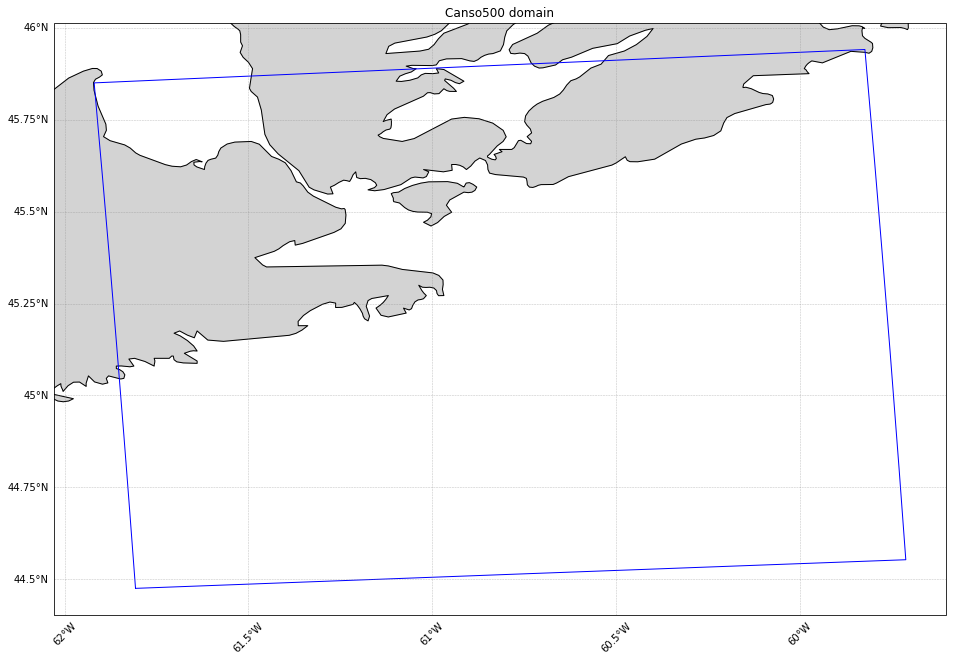

In [20]:
ax = setup_plot()
meshdir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions/problematic_drifter_output")
edge_lats = unpickle_var(os.path.join(meshdir, 'Canso500_edge_lats.pickle'))
edge_lons = unpickle_var(os.path.join(meshdir, 'Canso500_edge_lons.pickle'))
plt.plot(edge_lons, edge_lats, color='blue', linestyle='-', linewidth=1, label='Canso500')
plt.title('Canso500 domain')
savedir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions/retest_20221026/")
plt.savefig(os.path.join(savedir, 'Canso500_domain.png'))

## This plot was created using data that ran with the changes I've made to speed up the predictions. 

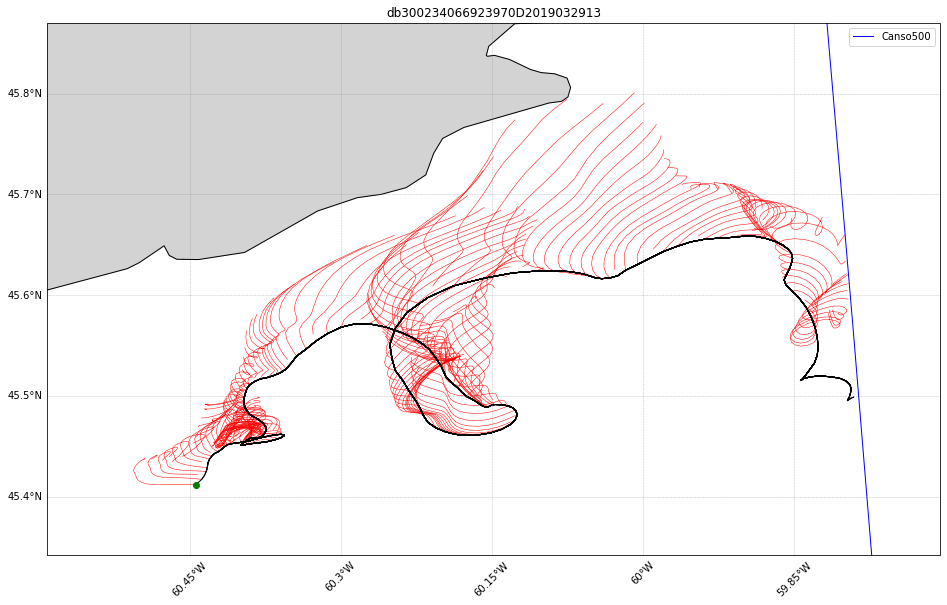

In [9]:
iss88dir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions/"
            + "retest_20221026/problematic_drifter_rerun_iss83branch/output_per_drifter/")
iss88file = os.path.join(iss88dir, 'db300234066923970D2019032913.nc_20190329-20190406_aggregated.nc')

create_plot(iss88file, iss88dir, set_extent=True)

## Next is an experiment that I ran using the develop branch and all of Adam's drifters. This version of develop has fixes for both the missing trajectory id and the name parsing issue. It does NOT have the new code that speeds up the predictions

### This first plot is comparable to the one above, so the new faster predictions are still giving the same results (in this case at least)

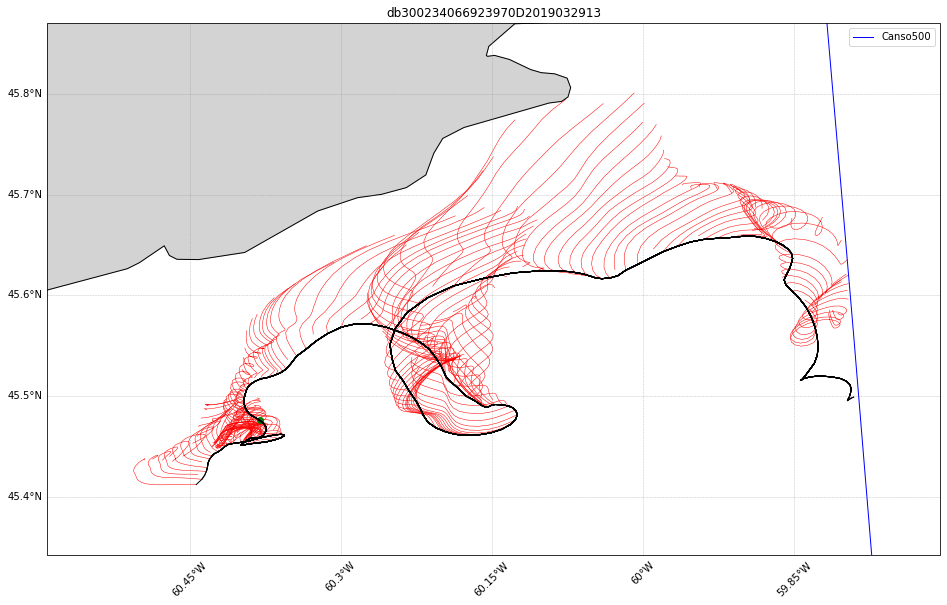

In [14]:
cansodir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions/"
            + "retest_20221026/full_dataset_rerun_develop-branch/output_per_drifter")
comparison_file = os.path.join(cansodir, 'db300234066923970D2019032913.nc_20190329-20190406_aggregated.nc')
create_plot(comparison_file, os.path.join(os.path.dirname(cansodir), 'comparison_plot'), set_extent=True)

### Here are the other drifters in that set. There's more data than what was created when Adam was encountering the error (ie, there are modelled drifters released at later times), but there are still only 4 drifters. I guess that's all that overlapped the correct time period. 

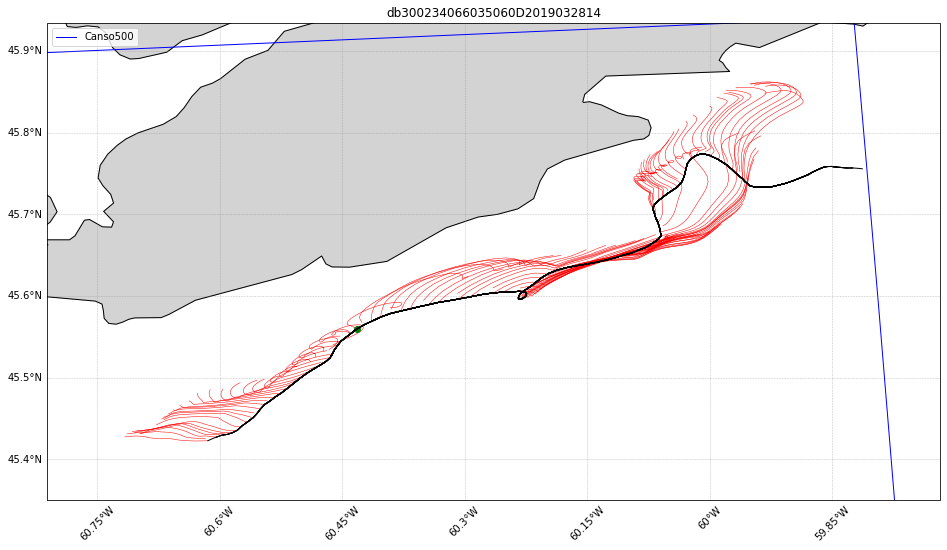

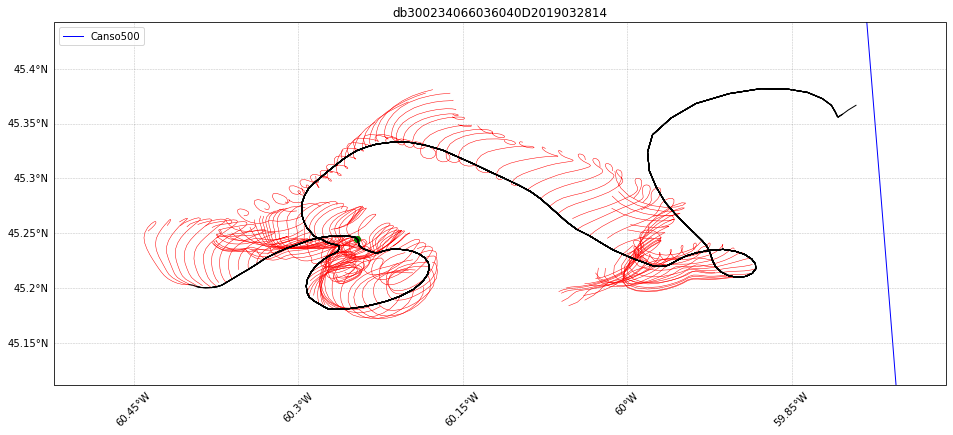

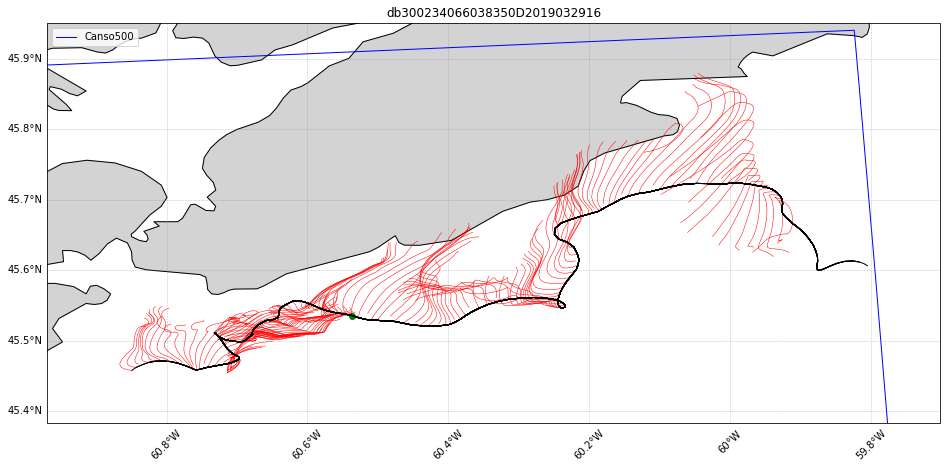

In [18]:
cansodir = ("C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions/"
            + "retest_20221026/full_dataset_rerun_develop-branch/output_per_drifter")
comparison_file = os.path.join(cansodir, 'db300234066923970D2019032913.nc_20190329-20190406_aggregated.nc')
canso_files = glob.glob(os.path.join(cansodir, '*.nc'))

for cfile in canso_files:
    if os.path.basename(cfile) == 'db300234066923970D2019032913.nc_20190329-20190406_aggregated.nc':
        continue  # no need to replot the same drifter as above!
    create_plot(cfile, os.path.join(os.path.dirname(cansodir), 'plots'), set_extent=True)